In [1]:
import pandas as pd
import numpy as np
import random
import math
import os
os.environ['PYTHONHASHSEED']=str(42)

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense
from keras import regularizers

In [2]:
# custom function for reproducibility
def custom_set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
custom_set_seed(42)

In [3]:
def all_df(filepath, hn_window, window):
    S = pd.read_csv(filepath, index_col = 0)
    ln_rtn = np.log(S / S.shift(1)).dropna()
    theta = np.var(ln_rtn, axis = 0)
    theta /= hn_window
    theta = theta.shift(1)
    mu = pd.concat([pd.DataFrame(np.mean(ln_rtn.iloc[i:i + window, :], axis = 0) / hn_window, columns = [ln_rtn.index[i + window]]).transpose() for i in range(ln_rtn.shape[0] - window)])
    V = pd.concat([pd.DataFrame(np.var(ln_rtn.iloc[i:i + window, :], axis = 0) / hn_window, columns = [ln_rtn.index[i + window]]).transpose() for i in range(ln_rtn.shape[0] - window)])
    # mu = pd.DataFrame(index = ln_rtn.index[window:], columns = ln_rtn.columns)
    # V = pd.DataFrame(index = ln_rtn.index[window:], columns = ln_rtn.columns)
    # for i in range(0, ln_rtn.shape[0] - window):
    #     mu.loc[ln_rtn.index[i + window], :] = np.mean(ln_rtn.iloc[i:i + window, :], axis = 0) / hn_window
    #     V.loc[ln_rtn.index[i + window], :] = np.var(ln_rtn.iloc[i:i + window, :], axis = 0) / hn_window
    return S, ln_rtn, theta, mu, V

In [4]:
T = 1.0
N = 23400
dt = T / N
window = 30 * 60
hn_window = dt * window

S_aapl, ln_rtn_aapl, theta_aapl, mu_aapl, V_aapl = all_df('./data/AAPL_20_23.csv', hn_window, window)
S_amgn, ln_rtn_amgn, theta_amgn, mu_amgn, V_amgn = all_df('./data/AMGN_20_23.csv', hn_window, window)

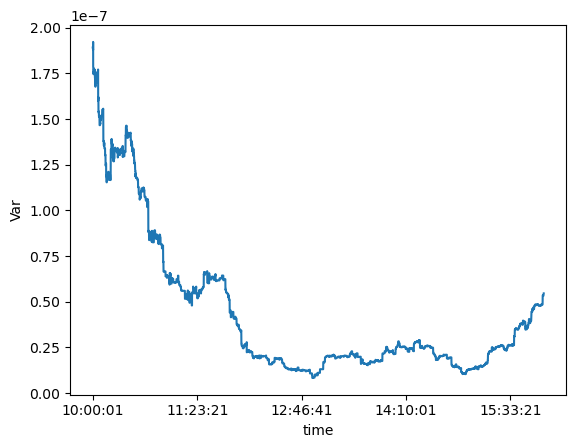

In [5]:
plt.figure()
plt.plot(V_aapl['2020-06-01'])
plt.ylabel('Var')
plt.xlabel('time')
plt.xticks(V_aapl.index[::5000])
plt.show()

In [6]:
def heston_slv_L(theta, kappa, rho, V, dt, ln_rtn, mu):
    mean = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    Z = np.random.multivariate_normal(mean, cov, V.shape)
    
    sigma = np.std(np.sqrt(theta))
    Vt = V + kappa * (theta - V) * dt + sigma * (V * dt).apply(lambda x: x ** 0.5) * Z[:,:,1]
    Vt[Vt < 0] = 0
    
    L = (ln_rtn - mu * dt) / ((Vt * dt).apply(lambda x: x ** 0.5) * Z[:,:,0])
    L = L.iloc[:, 1:].dropna()
    return L

In [7]:
kappa = 3
rho = 0.7

L_aapl = heston_slv_L(theta_aapl, kappa, rho, V_aapl, dt, ln_rtn_aapl, mu_aapl)
L_amgn = heston_slv_L(theta_amgn, kappa, rho, V_amgn, dt, ln_rtn_amgn, mu_amgn)

In [8]:
def prepare_train_and_test_dataset(L_list, V_list, val_split_rate, train_split_rate):
    L_list_train = []
    V_list_train = []
    L_list_val = []
    V_list_val = []
    L_list_test = []
    V_list_test = []
    for i in range(len(L_list)):
        col = L_list[i].shape[1]
        val_split = int(col * val_split_rate)
        train_split = int(col * train_split_rate)
        L_list_train.append(L_list[i].shift(1).dropna().iloc[:, :val_split])
        V_list_train.append(V_list[i].iloc[1:, 1:].iloc[:, :val_split])
        L_list_val.append(L_list[i].shift(1).dropna().iloc[:, val_split:train_split])
        V_list_val.append(V_list[i].iloc[1:, 1:].iloc[:, val_split:train_split])
        L_list_test.append(L_list[i].shift(1).dropna().iloc[:, train_split:])
        V_list_test.append(V_list[i].iloc[1:, 1:].iloc[:, train_split:])
    X_train = np.array([L.transpose().values.reshape(-1) for L in L_list_train]).transpose()
    Y_train = np.array([V.transpose().values.reshape(-1) for V in V_list_train]).transpose()
    X_val = np.array([L.transpose().values.reshape(-1) for L in L_list_val]).transpose()
    Y_val = np.array([V.transpose().values.reshape(-1) for V in V_list_val]).transpose()
    X_test = np.array([L.transpose().values.reshape(-1) for L in L_list_test]).transpose()
    Y_test = np.array([V.transpose().values.reshape(-1) for V in V_list_test]).transpose()
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [9]:
val_split_rate = 0.6
train_split_rate = 0.8
L_list = [L_aapl, L_amgn]
V_list = [V_aapl, V_amgn]
X_train, Y_train, X_val, Y_val, X_test, Y_test = prepare_train_and_test_dataset(L_list, V_list, val_split_rate, train_split_rate)

In [10]:
def build_model(drop_rate, lr, units, 
                no_features=1,
                no_outputs=1):
    """ Arguments
    drop_rate -- drop_rate in dropout
    learning_rate -- learning rate
    time_steps -- time steps for the sequence
    units -- number of hidden units or neurons
    no_features -- number of features, default 1 for a 1-dim time series
    no_outputs -- number of targets or outputs from the model
    """
    optim = tf.keras.optimizers.Adam(learning_rate=lr,
                            beta_1=0.9,
                            beta_2=0.999,
                            clipnorm=1.0)

    # TODO: how to implement many layers in keras?
    ret_seq = False
    model = Sequential()
    model.add(Input(shape=(no_features,)))
    model.add(BatchNormalization())
    [model.add(Dense(unit, kernel_regularizer=regularizers.l2(0.01), activation='relu')) for unit in units]
    # model.add(BatchNormalization(input_shape=(look_back, no_features)))
    # model.add(LSTM(units,input_shape=(look_back, no_features),
    #                return_sequences=ret_seq,
    #                kernel_regularizer=regularizers.l2(0.01),
    #                recurrent_regularizer=regularizers.l2(0.01),
    #                activation='relu'))
    # model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(BatchNormalization())
    model.add(Dense(no_outputs, kernel_regularizer=regularizers.l2(0.01)))
    model.compile(loss='mse',
                  optimizer=optim,
                  metrics=['mse'])
    return model

In [11]:
def train_model(X_train, Y_train, X_val, Y_val,
               epochs, drop_rate, batch_size, 
               lr, units):

    num_features = X_train.shape[-1]
    num_outputs = Y_train.shape[-1]
    model = build_model(drop_rate,
                        lr,
                        units,
                        no_features=num_features,
                        no_outputs=num_outputs)
    print(model.summary())

    history = model.fit(X_train,
                        Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_val, Y_val),
                        shuffle=True)
    return model, history

In [12]:
epochs = 5
drop_rate = 0.25
batch_size = 64
lr = 10e-5
units = [4]

model, history = train_model(X_train, Y_train, X_val, Y_val,
                             epochs, drop_rate, batch_size, 
                             lr, units)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 2)                   │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 4)                   │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46 (184.00 B)

 Trainable params: 34 (136.00 B)

 Non-trainable params: 12 (48.00 B)

None
Epoch 1/5
152206/152206 ━━━━━━━━━━━━━━━━━━━━ 454s 3ms/step - loss: 0.0483 - mse: 0.0397 - val_loss: 8.6877e-12 - val_mse: 8.6877e-12
Epoch 2/5
152206/152206 ━━━━━━━━━━━━━━━━━━━━ 461s 3ms/step - loss: 6.7161e-12 - mse: 6.7161e-12 - val_loss: 6.2694e-12 - val_mse: 6.2694e-12
Epoch 3/5
152206/152206 ━━━━━━━━━━━━━━━━━━━━ 468s 3ms/step - loss: 6.7282e-12 - mse: 6.7282e-12 - val_loss: 9.8708e-12 - val_mse: 9.8708e-12
Epoch 4/5
152206/152206 ━━━━━━━━━━━━━━━━━━━━ 467s 3ms/step - loss: 6.7275e-12 - mse: 6.7275e-12 - val_loss: 2.7116e-12 - val_mse: 2.7116e-12
Epoch 5/5
152206/152206 ━━━━━━━━━━━━━━━━━━━━ 456s 3ms/step - loss: 6.7205e-12 - mse: 6.7205e-12 - val_loss: 8.1414e-12 - val_mse: 8.1414e-12


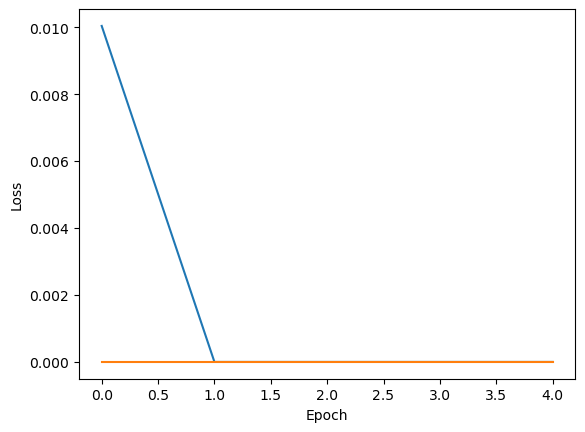

In [13]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
def evaluate(Y_test, Y_test_pred):
    """
    Function to calculate RMSE for one-dimensional arrays
    """
    mse = np.mean((Y_test - Y_test_pred) ** 2)
    rmse = np.sqrt(mse)
    MAX_POSSIBLE_RMSE = Y_test.std()
    normalized_rmse = (1 - rmse / MAX_POSSIBLE_RMSE)
    Grade = normalized_rmse
    return math.ceil(Grade * 100)

In [15]:
Y_test_pred = model.predict(X_test)

101921/101921 ━━━━━━━━━━━━━━━━━━━━ 165s 2ms/step


In [16]:
evaluate(Y_test, Y_test_pred)

-2308